# Euler schemes for Heston Model

Little collection of Euler Schemes for the simulation of the Heston model, as they were presented in the publication  
*A comparison of biased simulation schemes for stochastic volatility models* (Lord, Koekkoek and Van Dijk, 2005)  
The schemes are:
- **Absorption**
- **Partial truncation** (proposed by Deelstra and Delbaen in 1998)
- **Reflection** (proposed by Diop, Bossy and Berkaoui from 2003)
- **Higham and Mao** (proposed by Higham and Mao in 2005)
- **Full truncation** (proposed by Lord, Koekkoek and Van Dijk in 2005)  

The schemes are summarized in a function that generates _n_ simulations in a vectorized way, specifying among the parameters also the type of scheme to follow.  
The function uses the general formulation proposed in *paragraph 4.1* of the aforementioned paper, and the simulation of the asset price takes place by switching to the logarithms.

#### PROCESSES
$dv\left(t\right)=\kappa\left(\theta-v\left(t\right)\right)dt+\sigma\sqrt{\strut v\left(t\right)}dW_{v}\left(t\right)$  
$dS\left(t\right)=\mu S\left(t\right)dt+\sqrt{\strut v\left(t\right)}S\left(t\right)dW_{S}\left(t\right)$
#### ASSET VOLATILITY DISCRETISATION  
$\widetilde{v}\left(0\right)=v\left(0\right)$  
$\widetilde{v}\left(t+\Delta t\right)=f_{1}\left(\widetilde{v}(t)\right)+\kappa\Delta t\left(\theta-f_{2}\left(\widetilde{v}\left(t\right)\right)\right)+\sigma\sqrt{\strut f_{3}\left(\widetilde{v}\left(t\right)\right)\Delta t}\Delta W_{v}\left(t\right)$  
$v\left(t+\Delta t\right)=f_{3}\left(\widetilde{v}\left(t+\Delta t\right)\right)$  
#### ASSET PRICE DISCRETISATION  
$S\left(t+\Delta t\right)=S\left(t\right)e^{\left(\mu-\frac{1}{2}v\left(t\right)\right)\Delta t+\sqrt{\strut v\left(t\right)\Delta t}\Delta W_{S}\left(t\right)}$  
#### where
$f_{i}\left(x\right)=x$ for $x\geq 0$ and $i=1,2,3$  
$f_{i}\left(x\right)\geq 0$ for $x\in\mathbb{R}$ and $i=1,3$

#### FUNCTIONS $f_{i}$
- **Absorption**: $f_{i}(x)=\max\left(x,0\right)$ for $i=1,2,3$
- **Partial truncation**: $f_{1}\left(x\right)=f_{2}\left(x\right)=x$ and $f_{3}\left(x\right)=\max\left(x,0\right)$
- **Reflection**: $f_{i}(x)=|x|$ for $i=1,2,3$
- **Higham and Mao**: $f_{1}\left(x\right)=f_{2}\left(x\right)=x$ and $f_{3}\left(x\right)=|x|$
- **Full truncation**: $f_{1}\left(x\right)=x$ and $f_{2}\left(x\right)=f_{3}\left(x\right)=\max\left(x,0\right)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def heston_process(flt_v0, flt_theta, flt_kappa, flt_sigma, flt_rho, flt_S0, int_T, int_days, flt_mu, int_n, lst_schemes):
    """
    Function that simulates the Heston processes of asset-variance and asset-price with all schemes
    :param flt_v0: instantaneous variance at first instant
    :param flt_theta: long variance, or long run average price variance
    :param flt_kappa: rate at which the variance process reverts to flt_theta
    :param flt_sigma: volatility of the volatility
    :param flt_rho: correlation between the two Brownian Motions
    :param flt_S0: spot price of the asset at first instant
    :param int_T: time-to-maturity at first instant
    :param int_days: number of days the processes are observed
    :param flt_mu: rate of return of the asset
    :param int_n: number of processes to simulate
    :parama lst_schemes: list of Euler Schemes
    :return: dictionary with
             key = scheme
             value = array with shape (int_n, int_days, 2) with the values of asset-price and asset-variance for each day of each observation
    """
    dct_output = dict()
    # List with the "delta" between each step of the Brownian Motions
    lst_w = np.random.multivariate_normal(mean=np.array([0, 0]),
                                          cov=np.matrix([[1, flt_rho], [flt_rho, 1]]),
                                          size=(int_n, int_days))

    lst_w_s = lst_w[:, :, 0]
    lst_w_v = lst_w[:, :, 1]
    
    # Initialize simulations
    lst_st = np.zeros(shape=(int_n, int_T))
    lst_vt_hat = np.zeros(shape=(int_n, int_T))
    lst_vt = np.zeros(shape=(int_n, int_T))
    lst_st[:, 0] = flt_S0
    lst_vt_hat[:, 0] = flt_v0
    lst_vt[:, 0] = flt_v0
    flt_delta_t = 1/int_T
    
    # Define the f_i functions
    def f1(x, str_scheme):
        if str_scheme == "ABSORPTION":
            return np.maximum(x, 0)
        
        elif str_scheme == "REFLECTION":
            return np.abs(x)
        
        else:
            return x
        
    def f2(x, str_scheme):
        if str_scheme in ["ABSORPTION", "FULL"]:
            return np.maximum(x, 0)
        
        elif str_scheme == "REFLECTION":
            return np.abs(x)
        
        else:
            return x
        
    def f3(x, str_scheme):
        if str_scheme in ["ABSORPTION", "PARTIAL", "FULL"]:
            return np.maximum(x, 0)
        
        else:
            return np.abs(x)
    
    for str_scheme in lst_schemes:
        # Simulations step-by-step
        for int_t in range(int_T-1):
            # Next step for volatility
            lst_f1 = f1(x=lst_vt_hat[:, int_t],
                        str_scheme=str_scheme)

            lst_f2 = f2(x=lst_vt_hat[:, int_t],
                        str_scheme=str_scheme)

            lst_f3 = f3(x=lst_vt_hat[:, int_t],
                        str_scheme=str_scheme)

            lst_vt_hat[:, int_t+1] = lst_f1+flt_kappa*flt_delta_t*(flt_theta-lst_f2)+flt_sigma*np.sqrt(lst_f3*flt_delta_t)*lst_w_v[:, int_t+1]
            lst_vt[:, int_t+1] = f3(x=lst_vt_hat[:, int_t+1],
                                    str_scheme=str_scheme)

            # Next step for price
            lst_st[:, int_t+1] = lst_st[:, int_t]*np.exp((flt_mu-(lst_vt[:, int_t]/2))*flt_delta_t+np.sqrt(lst_vt[:, int_t]*flt_delta_t)*lst_w_s[:, int_t+1])
            
        dct_output[str_scheme] = np.concatenate([lst_st.reshape(int_n, -1, 1), lst_vt.reshape(int_n, -1, 1)],
                                                axis=2)
        
    return dct_output

In [3]:
# Parameters
flt_v0=0.1
flt_theta=0.001
flt_kappa=5
flt_sigma=0.5
flt_rho=-0.7
flt_S0=100
int_T=365
int_days=365
flt_mu=0
int_n=1000

In [4]:
# List of possible schemes
lst_schemes = ["ABSORPTION","PARTIAL","REFLECTION","HIGHAM_MAO","FULL"]

In [5]:
# Run the simulations
dct_results = heston_process(flt_v0=flt_v0,
                             flt_theta=flt_theta,
                             flt_kappa=flt_kappa,
                             flt_sigma=flt_sigma,
                             flt_rho=flt_rho,
                             flt_S0=flt_S0,
                             int_T=int_T,
                             int_days=int_days,
                             flt_mu=flt_mu,
                             int_n=int_n,
                             lst_schemes=lst_schemes)

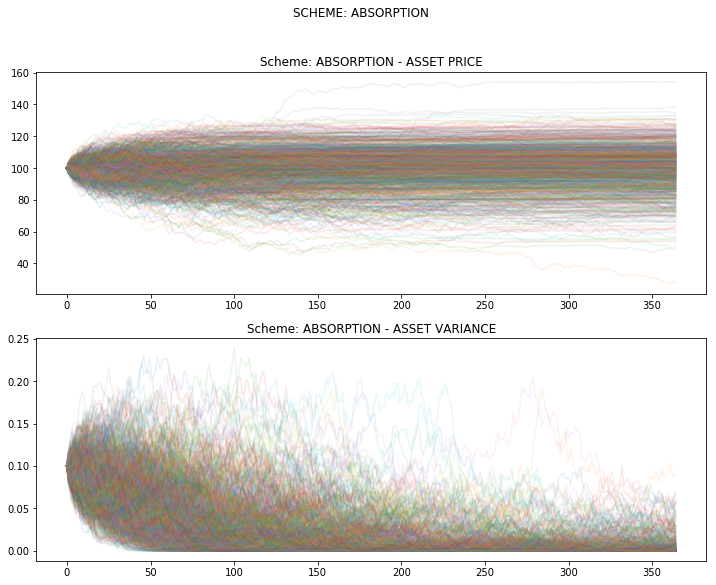

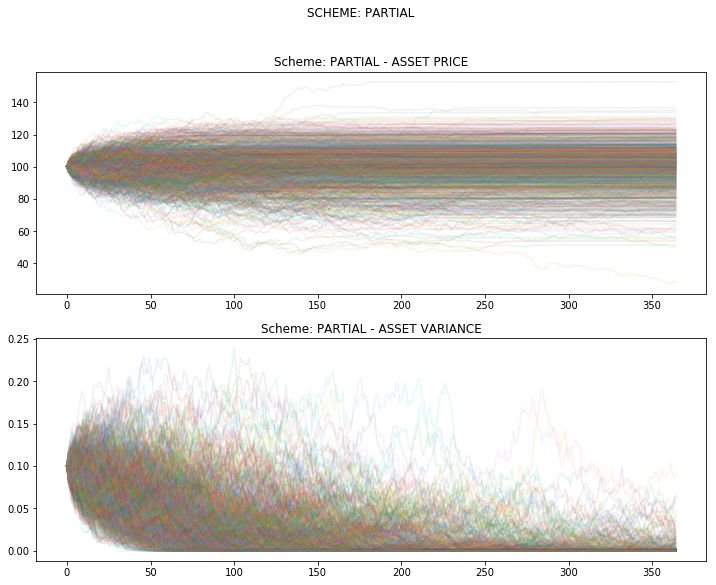

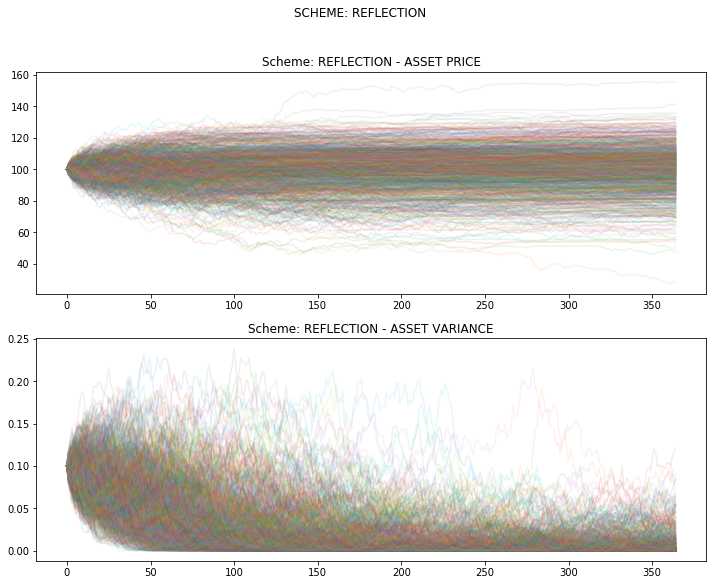

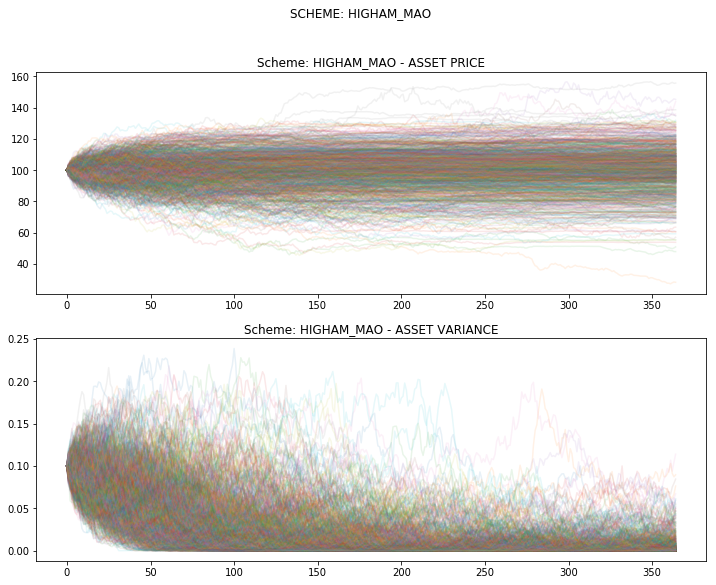

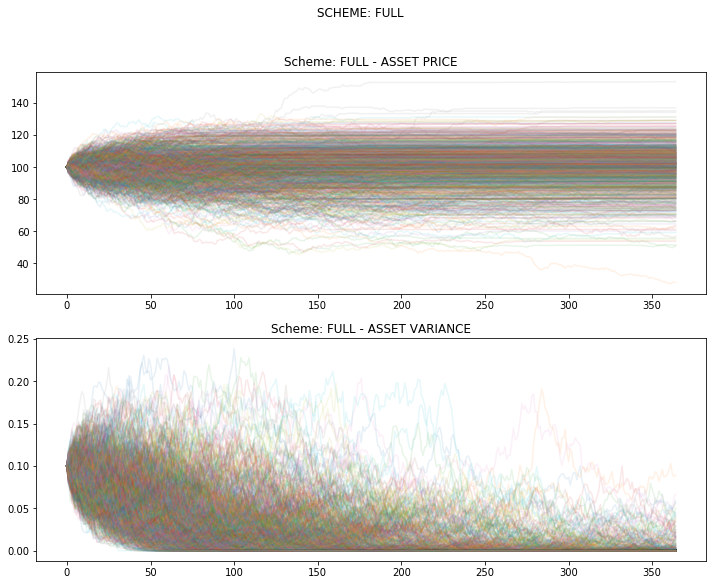

In [6]:
# Plot the simulations
for str_scheme in dct_results.keys():
    fig, ax =  plt.subplots(2,1,figsize=(12,9))
    fig.suptitle("SCHEME: "+str(str_scheme))
    ax[0].plot(dct_results[str_scheme][:,:,0].T,
               alpha=0.1)

    ax[0].set_title("Scheme: "+str(str_scheme)+" - ASSET PRICE")
    ax[1].plot(dct_results[str_scheme][:,:,1].T,
               alpha=0.1)

    ax[1].set_title("Scheme: "+str(str_scheme)+" - ASSET VARIANCE")
    plt.show()